In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from torch.autograd import Variable

import math

## Add & Norm
Residual & Normalization

SublayerConnection:
1. Residual:

$$x^{(l+1)} = f(x^{(l)}) + x^{(l)}$$

2. Normalization:

$$\text{LN}(x) = \alpha \cdot \frac{x - \mu}{\sigma} + b$$

3. Dropout

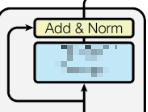

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, dim_size, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a = nn.Parameter(torch.ones(dim_size))
        self.b = nn.Parameter(torch.zeros(dim_size))
        self.eps = eps
        
    def forward(self, x):
        """E.g. (batch_size, seq_len, d_model)
        
        batch(i): 某一句子（样本）
                d1  d2  d3 ... d_model
            w1  1   3   5  ...   . 
            w2  2   4   6  ...   . 
            w3  3   6   9  ...   . 
            .   .   .   .  ...   .
            .   .   .   .  ...   .
            .   .   .   .  ...   .
            wseq_len.   .  ...   n
            
                d_mean
            w1   d_m1
            w2   d_m2
            w3   d_m3
            .     .
            .     .
            .     .
        """
        # Normalization: a(X - Xmean)/sqrt(Xvar + eps) + b
        mean = x.mean(-1, True)
        std = x.std(-1, True)
        return self.a * (x - mean)/math.sqrt(std + self.eps) + self.b

In [14]:
class SublayerConnection(nn.Module):
    def __init__(self, dim_size, dropout=0.1):
        super(SublayerConnection, self)
        self.layer_norm = LayerNorm(dim_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        # Residual: X = X + F(X)
        self.residual = x + sublayer(x)
        return self.dropout(self.layer_norm(self.residual))

## Muti-Head Attention
$$Z = \text{Softmax}\left(\frac{Q K^T - M}{\sqrt{d_k}}\right) V$$

1. Self-Attention

2. Mult-Head Attention

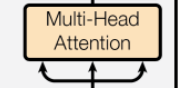

In [15]:
def self_attention(query, key, value, dropout=None, mask=None):
    # Q, K, V -> (batch_size, head_num, seq_len, head_dim)
    d_k = query.size(-1) # d_k <=> head_dim
    scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        mask.cuda()
        scores = scores.masked_fill(mask == 0, -1e9)
    weights = F.softmax(scores)
    if dropout is not None:
        weights = dropout(weights)
    return torch.matmul(weights, value), weights

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, head, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert (d_model % head == 0)
        self.d_k = d_model // head
        self.head = head
        self.d_model = d_model
        self.weights = None
        
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        # self.linears = [self.linear_query, self.linear_key, self.linear_value]
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # (batch_size, seq_len, seq_len)
            mask = mask.unsqueeze(1)
        batch_size = query.size(0)
        
        query = self.linear_query(query).view(batch_size, -1, self.head, self.d_k).transpose(1, 2)
        key = self.linear_query(key).view(batch_size, -1, self.head, self.d_k).transpose(1, 2)
        value = self.linear_value(value).view(batch_size, -1, self.head, self.d_k).transpose(1, 2)
        # query, key, value = [L(x).view(batch_size, -1, self.head, self.d_k).transpose(1, 2) for L, x in zip(self.linears, (query, key, value))]
        
        x, self.weights = self_attention(query, key, value, mask, self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.linear_out(x)

## Word Embedding

### Positional Encoding


$$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right) = \sin\left(\text{pos} \times e^{-\frac{2i}{d} \ln 10000}\right) $$


$$PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right) = \cos\left(\text{pos} \times e^{-\frac{2i}{d} \ln 10000}\right) $$


PE_NOTICE:

Graidient Decend ❌ 
Variable ⭕
=> Buffer

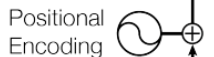


### Input/Output Embedding

* nn.Embedding(vocab_size, d_model)

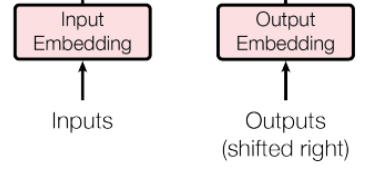


$$ Word Embedding $$
$$ = Input/OutputEmbedding + Positional Encoding $$

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, seq_len=5000):
        super(PositionalEncoding, self).__init__
        self.dropout = nn.Module(dropout)
        # pe: (seq_len, d_model)
        # pos: (seq_len, 1)
        # div: (d_model/2)
        pe = torch.zero(seq_len, d_model)
        pos = torch.arange(0, seq_len).unsqueeze(1)
        div = torch.exp(- torch.arange(0, d_model, 2)/d_model * math.log(10000))
        
        # pos * div == Broadcast ==> (seq_len, d_model/2)
        pe[:, 0::2] = math.sin(pos * div)
        pe[:, 1::2] = math.cos(pos * div)        
        
        # pe: (seq_len, d_model) => (batch_size, seq_len, d_model)
        pe = pe[:seq_len, :].sqeeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return self.dropout(x + Variable(self.pe, False))

In [18]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

## Feed Forward

$$FFN(x)= W2 \times (ReLU(W1 \times x +b1)) + b2$$

$$^*FFN(x)= W2 \times (ReLU(W1 \times Norm(x) +b1)) + b2$$

$$^*FFN(x)= W2 \times (Dropout(ReLU(W1 \times x +b1))) + b2$$

$$^*FFN(x)= Dropout(W2 \times (ReLU(W1 \times x +b1)) + b2)$$

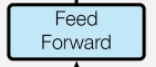

In [19]:
class FeedForward(nn.Module):
    def __init__(self, d_ff, d_model, dropout=0.1):
        super(FeedForward, self).__init__()
        self.norm = LayerNorm(d_ff)
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = F.relu
    
    def forward(self, x):
        return self.dropout2(self.w_2(self.dropout1(self.relu(self.w_1(self.norm(x))))))

## Generator

$$G(x)= Softmax ( Wx + b)$$

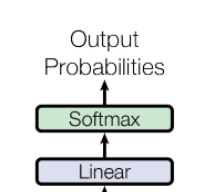

In [20]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = F.log_softmax(vocab_size, dim=-1)
        
    def forward(self, x):
        return self.softmax(self.linear(x))

## Mask


In [21]:
def subsequence_mask(size):
    scores = (1, size, size)
    mask = np.triu(torch.one(scores), k=1).astype('uint8')
    return (torch.from_numpy(mask) == 0).cuda()

# Structure
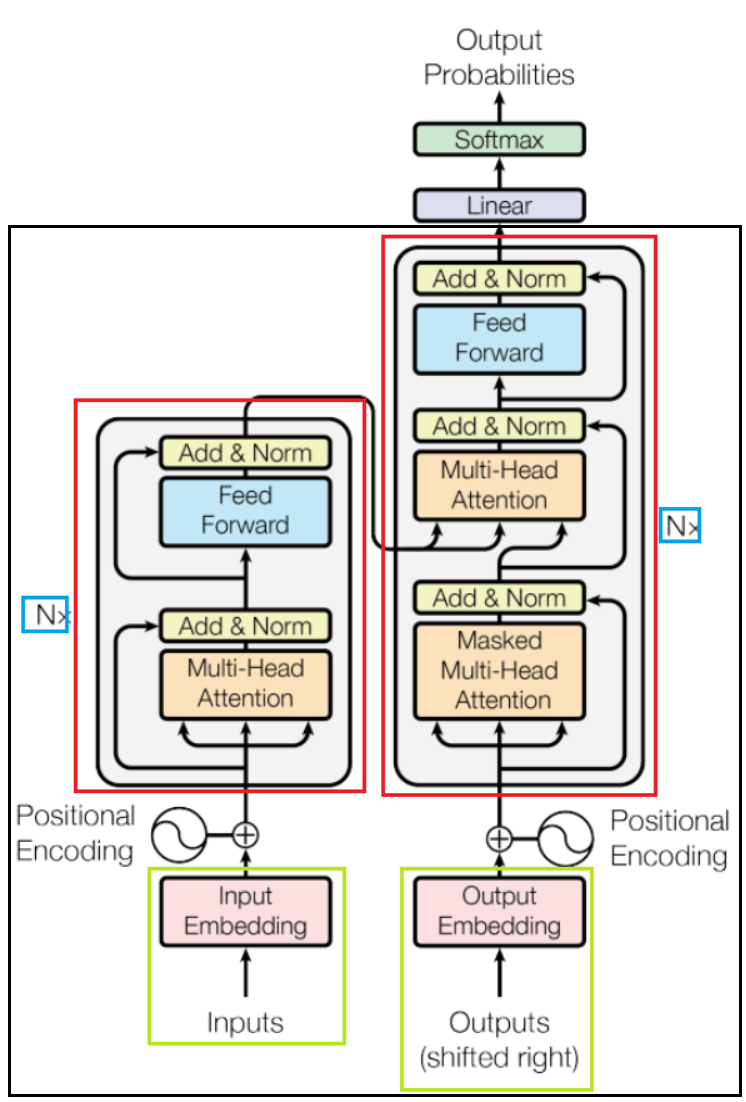

### clones

Including Layers & Sublayers:

Encoder, Decoder, Multi-Head Attention...

In [22]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Encoder

MultiHeadAttention


 -> SublayerConnection


 -> FeedForward


 -> SublayerConnection

In [23]:
class EncoderLayer(nn.Module):
    def __init__(self, dim_size, multi_head_attention, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.multi_head_attention = multi_head_attention
        self.feed_forward = feed_forward
        self.sublayers = clones(SublayerConnection(dim_size, dropout), 2)
        self.dim_size = dim_size
        
    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x: self.multi_head_attention(x, x, x, mask))
        x = self.sublayers[1](x, self.feed_forward)
        return x       

In [24]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Decoder

MaskedMultiHeadAttention


 -> SublayerConnection


 -> MultiHeadAttention


 -> SublayerConnection


 -> FeedForward


 -> SublayerConnection

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, dim_size, masked_multi_head_attention, multi_head_attention, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.masked_multi_head_attention = masked_multi_head_attention
        self.multi_head_attention = multi_head_attention
        self.feed_forward = feed_forward
        self.layers = clones(SublayerConnection(dim_size, dropout), 3)
        
    def forward(self, x, memory, tgt_mask, src_mask):
        m = memory
        x = self.layers[0](x, lambda x: self.masked_multi_head_attention(x, x, x, tgt_mask))
        x = self.layers[1](x, lambda x: self.multi_head_attention(x, m, m, src_mask))
        x = self.layers[2](x, self.feed_forward)
        return x

In [26]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, tgt_mask, src_mask):
        for layer in self.layers:
            x = layer(x, memory, tgt_mask, src_mask)
        return self.norm(x)

## Encoder-Decoder

In [27]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask) 
           
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

## Transformer

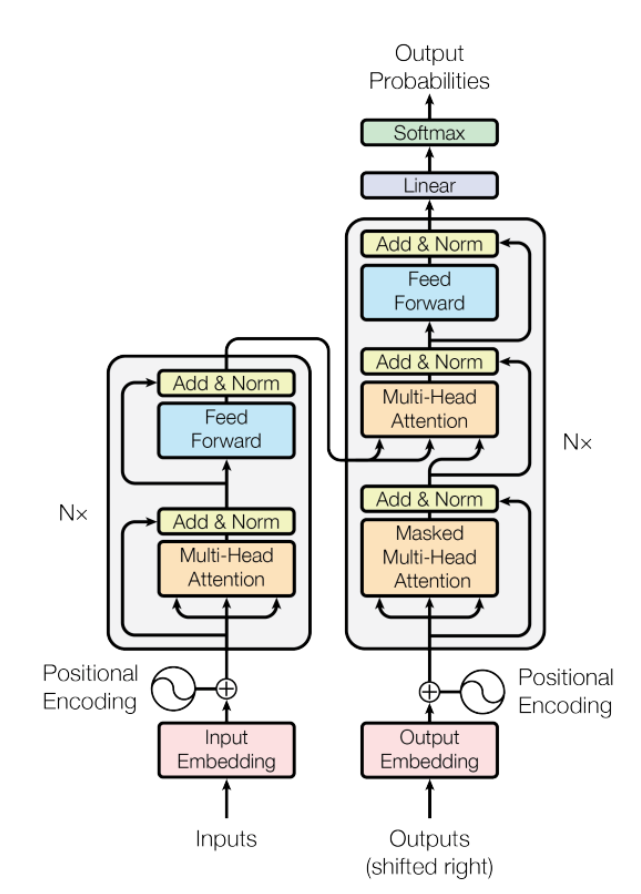

In [28]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, N=6, d_model=512, d_ff=2048, head=8, dropout=0.1):
        super(Transformer, self).__init__()

        # Input
        position = PositionalEncoding(d_model, dropout)
        src_embed = nn.Sequential(Embeddings(src_vocab_size, d_model), position)
        tgt_embed = nn.Sequential(Embeddings(tgt_vocab_size, d_model), position)
        # Process
        atten = MultiHeadAttention(d_model, head, dropout)
        ff = FeedForward(d_model, d_ff, dropout)
        encoder = Encoder(EncoderLayer(d_model, atten, ff, dropout), N)
        decoder = Decoder(DecoderLayer(d_model, atten, atten, ff, dropout), N)
        # Output
        generator = Generator(d_model, tgt_vocab_size)
        
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        self.d_model = d_model
        
        # Model
        self.model = EncoderDecoder(src_embed, tgt_embed, encoder, decoder, generator)